This image is: <class 'numpy.ndarray'> with all dimesions: (540, 960, 3)
[MoviePy] >>>> Building video C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/solidWhiteRight_final_op1.mp4
[MoviePy] Writing video C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/solidWhiteRight_final_op1.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 221/222 [00:09<00:00, 24.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/solidWhiteRight_final_op1.mp4 

Wall time: 9.77 s


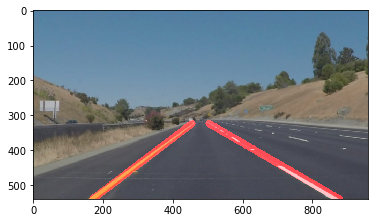

In [4]:



# coding: utf-8

# In[19]:

#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
get_ipython().magic('matplotlib inline')
import math
import os

import imageio
imageio.plugins.ffmpeg.download()
import glob

#reading in an image
image = mpimg.imread('C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/solidYellowCurve2.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with all dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image



# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def find_laneline(image):
    # call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    gray = grayscale(image)
    # plt.imshow(gray, cmap='gray')
    # plt.show()

    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 5  # Must be an odd number (3, 5, 7...)
    blur_gray = gaussian_noise(gray, kernel_size)

    # Define our parameters for Canny and run it
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Display the image
    #plt.imshow(edges, cmap='Greys_r')
    #plt.show()


    # region mask

    # This time we are defining a four sided polygon to mask
    imshape = image.shape

    bottom_offset = 55
    img_height = imshape[0]
    img_width = imshape[1]

    # (W, H) == (x, y)
    vertices = np.array([
        [
            (bottom_offset, img_height),  # bottom left
            (img_width * 0.48, img_height * 0.60),  # top left
            (img_width * 0.54, img_height * 0.60),  # top right
            (img_width - bottom_offset, img_height)  # bottom right
        ]
    ], dtype=np.int32)

    # print('region of interest vertices: ', vertices)

    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    #
    # Defaults:
    # rho = 1
    # theta = np.pi/180
    # threshold = 1
    # min_line_length = 10
    # max_line_gap = 1

    rho = 2
    theta = np.pi / 180
    threshold = 40
    min_line_length = 10
    max_line_gap = 40

    result = hough_lines(image, masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))

    α = 0.8
    β = 1.
    λ = 0.
    result = weighted_img(result, image, α, β, λ)

    return result

dirs=os.listdir("C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/")

#for file in dirs:
#   imagew = mpimg.imread(file)
#    imageww=find_laneline(imagew)
#plt.imshow(imageww) #

#from PIL import Image
#import glob
#image_list = []
#for filename in glob.glob('C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/*.jpg'): #assuming gif
#    im=find_laneline(filename)
#    plt.imshow(im)

# Read in the image - below working code
out_dir='C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/'
image1 = mpimg.imread('C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/solidYellowLeft.jpg')
imgae_test=find_laneline(image1)
plt.imshow(imgae_test)
plt.imsave(out_dir+'straight_solidYellowLeft.jpg',imgae_test)

image2 = mpimg.imread('C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/whiteCarLaneSwitch.jpg')
imgae_test2=find_laneline(image2)
plt.imshow(imgae_test2)
plt.imsave(out_dir+'straight_whiteCarLaneSwitch.jpg',imgae_test2)

image3 = mpimg.imread('C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/solidYellowCurve2.jpg')
imgae_test3=find_laneline(image3)
plt.imshow(imgae_test3)
plt.imsave(out_dir+'straight_solidYellowCurve2.jpg',imgae_test3)

white_output = 'C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/solidWhiteRight_final_op1.mp4'
clip1 = VideoFileClip("C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/solidWhiteRight.mp4")
white_clip = clip1.fl_image(find_laneline)
get_ipython().magic('time white_clip.write_videofile(white_output, audio=False)')

#images1 = glob.glob('C:/Users/vikas/Desktop/nanodeg/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/*.jpg')
# Visualize undistortion on test images

#for fname in images1:
#    cv2.imshow('dst',dst)
 #   cv2.waitKey(500)


